# Solving the Stefan problem with adaptive finite elements

This Jupyter notebook shows how to solve the Stefan problem with finite elements and goal-oriented adaptive mesh refinement (AMR) using FEniCS.

## Python packages

Import the Python packages for use in this notebook.

We use the finite element method library FEniCS.

In [1]:
import fenics

|Note|
|----|
| This Jupyter notebook server is using FEniCS 2017.2.0 from ppa:fenics-packages/fenics, installed via `apt` on Ubuntu 16.04.|

FEniCS has convenient plotting features that don't require us to import `matplotlib`; but using `matplotlib` directly will allow us to annotate the plots.

In [2]:
import matplotlib

Tell this notebook to embed graphical outputs from `matplotlib`, includings those made by `fenics.plot`.

In [3]:
%matplotlib inline

We will also use numpy.

In [4]:
import numpy

## Nomenclature
|||
|-|-|
|$\mathbf{x}$| point in the spatial domain|
|$t$| time |
|$T = T(\mathbf{x},t)$| temperature field |
|$\phi$ | solid volume fraction |
|$()_t = \frac{\partial}{\partial t}$| time derivative |
|$T_r$| central temperature of the regularization |
|$r$| smoothing parameter of the regularization |
|$\mathrm{Ste}$| Stefan number|
|$\Omega$| spatial domain |
|$\mathbf{V}$| finite element function space |
|$\psi$| test function |
|$T_h$| hot boundary temperature |
|$T_c$| cold boundary temperature |
|$\Delta t$| time step size |
|$\Omega_h$| discrete spatial domain, i.e. the mesh |
|$M$| goal functional |
|$\epsilon_M$| error tolerance for goal-oriented AMR |

## Governing equations

To model the Stefan problem with a single domain, consider the enthalpy balance from [4] with zero velocity and unit Prandtl number.

\begin{align*}
    T_t - \nabla \cdot (\nabla T) - \frac{1}{\mathrm{Ste}}\phi_t &= 0
\end{align*}

where the regularized semi-phase-field (representing the solid volume fraction) is 

\begin{align*}
    \phi(T) = \frac{1}{2}\left(1 + \tanh{\frac{T_r - T}{r}} \right)
\end{align*}

This is essentially a smoothed heaviside function, which approaches the exact heaviside function as $r$ approaches zero. Let's visualize this.

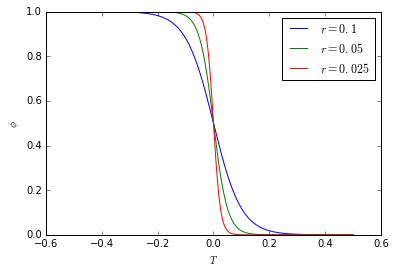

In [5]:
def semi_phase_field(T, T_r, r):
    
    return 0.5*(1. + numpy.tanh((T_r - T)/r))


regularization_central_temperature = 0.

temperatures = numpy.linspace(
    regularization_central_temperature - 0.5,
    regularization_central_temperature + 0.5,
    1000)

legend_strings = []

for regluarization_smoothing_parameter in (0.1, 0.05, 0.025):
    
    matplotlib.pyplot.plot(
        temperatures, 
        semi_phase_field(
            T = temperatures, 
            T_r = regularization_central_temperature, 
            r = regluarization_smoothing_parameter))
    
    legend_strings.append(
        "$r = " + str(regluarization_smoothing_parameter) + "$")
    
matplotlib.pyplot.xlabel("$T$")

matplotlib.pyplot.ylabel("$\phi$")

matplotlib.pyplot.legend(legend_strings)

## Mesh

Define a fine mesh to capture the rapid variation in $phi(T)$.

In [6]:
N = 1000

mesh = fenics.UnitIntervalMesh(N)

## Finite element function space, test function, and solution function

Lets use piece-wise linear elements.

In [7]:
P1 = fenics.FiniteElement('P', mesh.ufl_cell(), 1)

|Note|
|----|
|`fenics.FiniteElement` requires the `mesh.ufl_cell()` argument to determine some aspects of the domain (e.g. that the spatial domain is two-dimensional).|

Make the finite element function space $V$, which enumerates the finite element basis functions on each cell of the mesh.

In [8]:
V = fenics.FunctionSpace(mesh, P1)

Make the test function $\psi  \in \mathbf{V}$.

In [9]:
psi = fenics.TestFunction(V)

Make the solution function $T \in \mathbf{V}$.

In [10]:
T = fenics.Function(V)

### Benchmark parameters

Set the Stefan number, density, specific heat capacity, and thermal diffusivity. For each we define a `fenics.Constant` for use in the variational form so that FEniCS can more efficiently compile the finite element code.

In [11]:
stefan_number = 0.045

Ste = fenics.Constant(stefan_number)

Define the regularized semi-phase-field for use with FEniCS.

In [12]:
regularization_central_temperature = 0.

T_r = fenics.Constant(regularization_central_temperature)

regularization_smoothing_parameter = 0.005

r = fenics.Constant(regularization_smoothing_parameter)

tanh = fenics.tanh

def phi(T):
    
    return 0.5*(1. + fenics.tanh((T_r - T)/r))

Furthermore the benchmark problem involves hot and cold walls with constant temperatures $T_h$ and $T_c$, respectively.

In [13]:
hot_wall_temperature = 1.

T_h = fenics.Constant(hot_wall_temperature)

cold_wall_temperature = -0.01

T_c = fenics.Constant(cold_wall_temperature)

### Time discretization

To solve the initial value problem, we will prescribe the initial values, and then take discrete steps forward in time which solve the governing equations.

We set the initial values such that a small layer of melt already exists touching the hot wall.

\begin{align*}
    T^0 = 
    \begin{cases}
        T_h, && x_0 < x_{m,0} \\
        T_c, && \mathrm{otherwise}
    \end{cases}
\end{align*}

Interpolate these values to create the initial solution function.

In [14]:
initial_melt_thickness = 10./float(N)

T_n = fenics.interpolate(
    fenics.Expression(
        "(T_h - T_c)*(x[0] < x_m0) + T_c",
        T_h = hot_wall_temperature, 
        T_c = cold_wall_temperature,
        x_m0 = initial_melt_thickness,
        element = P1),
    V)

Let's look at the initial values now.

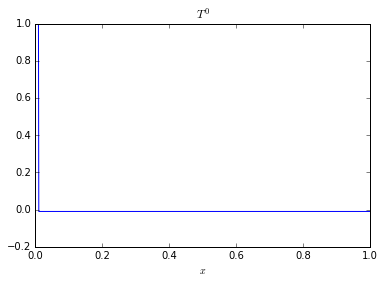

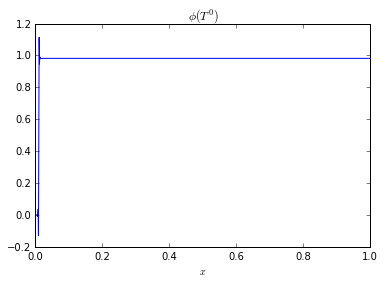

In [15]:
fenics.plot(T_n)

matplotlib.pyplot.title(r"$T^0$")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.show()

fenics.plot(phi(T_n))

matplotlib.pyplot.title(r"$\phi(T^0)$")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.show()

For the time derivative terms, we apply the first-order implicit Euler finite difference time discretization, i.e.

\begin{align*}
    T_t = \frac{T^{n+1} - T^n}{\Delta t} \\
    \phi_t = \frac{\phi\left(T^{n+1}\right) - \phi\left(T^n\right)}{\Delta t} 
\end{align*}

|Note|
|----|
|We will use the shorthand $T = T^{n+1}$, since we will always be solving for the latest discrete time.|

Choose a time step size and set the discrete time derivatives.

In [16]:
timestep_size = 1.e-3

Delta_t = fenics.Constant(timestep_size)

T_t = (T - T_n)/Delta_t

phi_t = (phi(T) - phi(T_n))/Delta_t

## Variational form

To obtain the finite element weak form, we follow the standard Ritz-Galerkin method. Therefore, we multiply the strong form *from the left* by the test function $\psi$ from the finite element function space $V$ and integrate over the spatial domain $\Omega$. This gives us the variational problem: Find $T \in V$ such that

\begin{align*}
    (\psi,T_t - \frac{1}{\mathrm{Ste}}\phi_t) + (\nabla \psi, \nabla T) = 0 \quad \forall \psi \in V
\end{align*}

|Note| 
|----|
|We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$.|

Define the nonlinear variational form for FEniCS.

|Note|
|----|
|The term $\phi(T)$ is nonlinear.|

In [17]:
dot, grad = fenics.dot, fenics.grad
    
F = (psi*(T_t - 1./Ste*phi_t) + dot(grad(psi), grad(T)))*fenics.dx

## Linearization
Notice that $\mathcal{F}$ is a *nonlinear* variational form. FEniCS will solve the nonlinear problem using Newton's method. This requires computing the Jacobian (formally the Gâteaux derivative) of the nonlinear variational form, yielding a a sequence of linearized problems whose solutions may converge to approximate the nonlinear solution.

We could manually define the Jacobian; but thankfully FEniCS can do this for us.

|Note|
|----|
|When solving linear variational problems in FEniCS, one defines the linear variational form using `fenics.TrialFunction` instead of `fenics.Function` (while both approaches will need `fenics.TestFunction`). When solving nonlinear variational problems with FEniCS, we only need `fenics.TrialFunction` to define the linearized problem, since it is the linearized problem which will be assembled into a linear system and solved.|

In [18]:
JF = fenics.derivative(F, T, fenics.TrialFunction(V))

## Boundary conditions

We need boundary conditions before we can define a variational *problem* (i.e. in this case a boundary value problem).

We consider a constant hot temperature on the left wall, a constant cold temperature on the right wall. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*}
    T(\mathbf{x}) &= 
    \begin{cases}
        T_h , && x_0 = 0 \\
        T_c , && x_0 = 1 
    \end{cases}
\end{align*}

In [19]:
hot_wall = "near(x[0],  0.)"

cold_wall = "near(x[0],  1.)"

Define the boundary conditions for FEniCS.

In [20]:
boundary_conditions = [
    fenics.DirichletBC(V, hot_wall_temperature, hot_wall),
    fenics.DirichletBC(V, cold_wall_temperature, cold_wall)]

## The variational problem

Now we have everything we need to define the variational problem for FEniCS.

In [21]:
problem = fenics.NonlinearVariationalProblem(F, T, boundary_conditions, JF)

## The benchmark solution

Finally we instantiate the adaptive solver with our problem and goal

In [22]:
solver = fenics.NonlinearVariationalSolver(problem)

and solve the problem to the prescribed tolerance.

In [23]:
solver.solve()

(10, 1)

|Note|
|----|
|`solver.solve` will modify the solution `w`, which means that `u` and `p` will also be modified.|

Now plot the temperature and solid volume fraction.

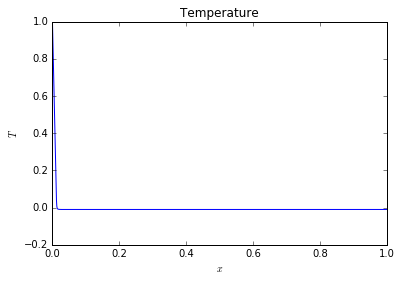

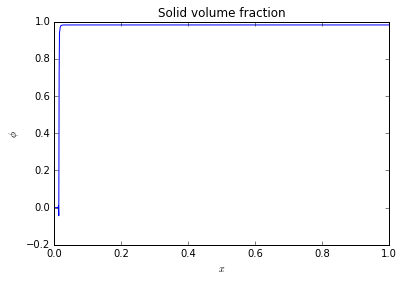

In [24]:
def plot(T):

    fenics.plot(T)

    matplotlib.pyplot.title("Temperature")

    matplotlib.pyplot.xlabel("$x$")

    matplotlib.pyplot.ylabel("$T$")
    
    matplotlib.pyplot.show()
    
    
    fenics.plot(phi(T))

    matplotlib.pyplot.title("Solid volume fraction")

    matplotlib.pyplot.xlabel("$x$")

    matplotlib.pyplot.ylabel("$\phi$")
    
    matplotlib.pyplot.show()
    
    
plot(T)

Let's run further.

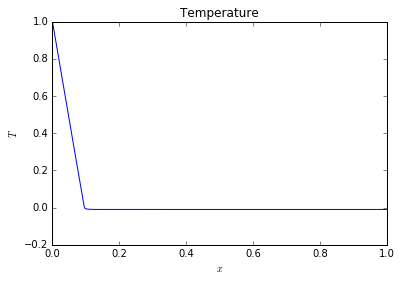

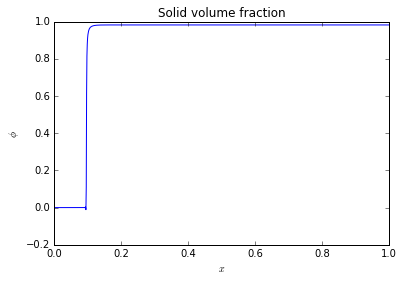

In [25]:
for timestep in range(100):
    
    T_n.vector()[:] = T.vector()
    
    solver.solve()
    
plot(T)

## References
[1] W Bangerth and R Rannacher. **Adaptive Finite Element Methods for Differential Equations**. *Springer Science & Business Media*, 2003.

[2] A Logg, KA Mardal, and GN Wells. **Automated Solution of Differential Equations by the Finite Element Method**, *Springer*, 2012.

[3] VR Voller, CR Swaminathan, and BG Thomas. **Fixed grid techniques for phase change problems: a review.** *International Journal of Numerical Methods and Engineering*, 30(4):875–898, 1990.

[4] AG Zimmerman and J Kowalski. **Monolithic simulation of convection-coupled phase-change - verification and reproducibility.** *arXiv:1801.03429 [physics.flu-dyn]*, 2018.